## Stage 02: Volatility Calculation
Compute the realized volatility from the historical summary and forward-looking volatility using GARCH(1,1).

In [91]:
# project path
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().parent
SRC_PATH = PROJECT_ROOT / "src"

if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))


### Load Stock Data

In [93]:
from pathlib import Path
import pandas as pd
from options_valuation.config import data_dir

def load_latest_price_data():
    raw_dir = Path(data_dir()) / "raw"
    files = sorted(
        raw_dir.glob("*_daily_*.csv"),
        key=lambda p: p.stat().st_mtime,
        reverse=True,
    )

    if not files:
        raise FileNotFoundError("No price data found in data/raw.")

    latest = files[0]
    ticker = latest.name.split("_")[0]

    df = pd.read_csv(latest)
    return ticker, df

ticker, df = load_latest_price_data()
print("Loaded ticker:", ticker)

# Basic Sanity Checks
print(df.columns)
print(df.dtypes)
print("Rows:", len(df))
print("Date range:", df["date"].min(), "->", df["date"].max())


Loaded ticker: AAPL
Index(['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume'], dtype='object')
date          object
open         float64
high         float64
low          float64
close        float64
adj_close    float64
volume         int64
dtype: object
Rows: 502
Date range: 2024-01-08 -> 2026-01-07


### Compute Daily Log Return

In [95]:
import numpy as np
# Use adjusted close if available
price_col = "adj_close" if "adj_close" in df.columns else "close"
print("Using price column:", price_col)

# Compute daily log return
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

df["log_return"] = np.log(df[price_col] / df[price_col].shift(1))
df = df.dropna().reset_index(drop=True)

display(df[["date", price_col, "log_return"]].head())

# Basic statistics
print("Mean log return:", df["log_return"].mean())
print("Std log return (daily):", df["log_return"].std())

Using price column: adj_close


,date,adj_close,log_return
0,2024-01-09,183.407898,-0.002266
1,2024-01-10,184.448074,0.005655
2,2024-01-11,183.853683,-0.003228
3,2024-01-12,184.180603,0.001777
4,2024-01-16,181.912033,-0.012394


Mean log return: 0.0006945534579214877
Std log return (daily): 0.01743165551508278


### Save the Daily Log Return
Save the daily log return in data/processed/ folder

In [97]:
from pathlib import Path
from options_valuation.config import data_dir

processed_dir = Path(data_dir()) / "processed"
processed_dir.mkdir(parents=True, exist_ok=True)

out_path = processed_dir / f"{ticker}_log_return_daily.csv"

df[["date", price_col, "log_return"]].to_csv(out_path, index=False)

print("Saved log returns to:", out_path)

Saved log returns to: /Users/allenpilipala/BSM_model/data/processed/AAPL_log_return_daily.csv


### Plot the Daily Log Return over 2 years
Plot the log return and save it to the docs/ folder

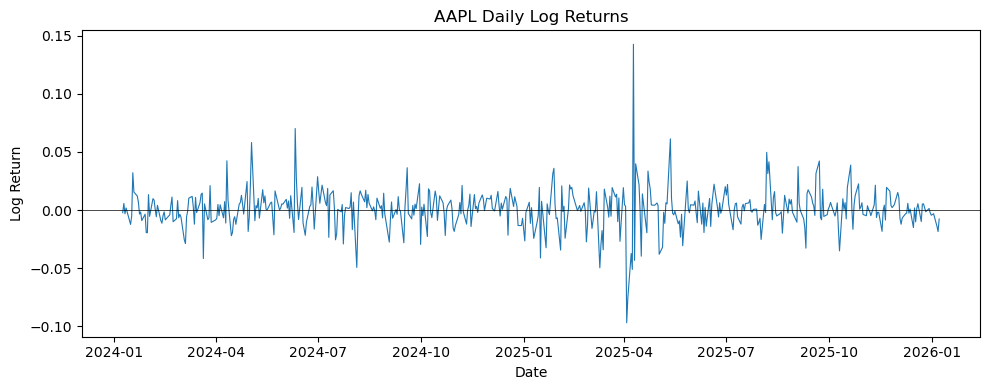

Log return plot saved to: /Users/allenpilipala/BSM_model/docs/AAPL_daily_log_return.png


In [99]:
import matplotlib.pyplot as plt
from pathlib import Path
from options_valuation.config import data_dir

# Prepare output directory
docs_dir = Path(data_dir()).parent / "docs"
docs_dir.mkdir(parents=True, exist_ok=True)

# Plot log returns
plt.figure(figsize=(10, 4))
plt.plot(df["date"], df["log_return"], linewidth=0.8)
plt.axhline(0, color="black", linewidth=0.5)
plt.title(f"{ticker} Daily Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.tight_layout()
plt.show()

# Save figure
out_path = docs_dir / f"{ticker}_daily_log_return.png"
plt.savefig(out_path, dpi=300)
plt.close()

print("Log return plot saved to:", out_path)


### Realized (Histroical) Volatility

In [101]:
# Daily realized volatility
sigma_daily_realized = df["log_return"].std()
print("Realized Daily Volatility: ", sigma_daily_realized)

# annulized volatility based on the daily realized volatility
sigma_annual_realized = sigma_daily_realized * np.sqrt(252)
print("Annualized volatility: ", sigma_annual_realized)

Realized Daily Volatility:  0.01743165551508278
Annualized volatility:  0.2767189525983394


### Rolling Volatility

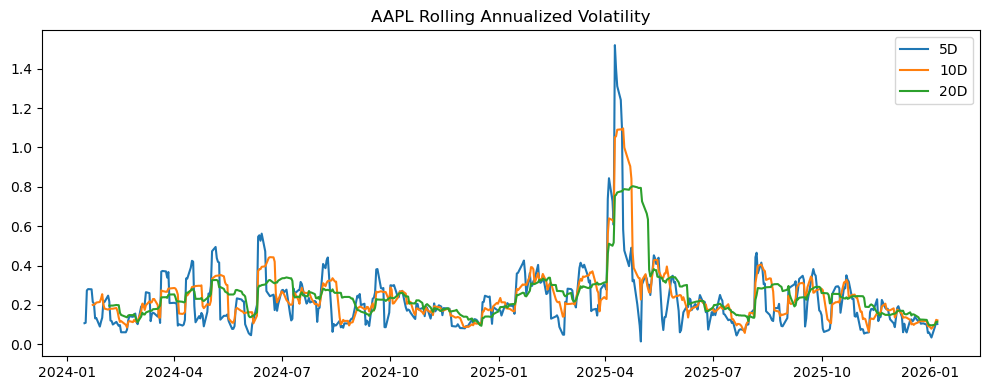

Log return plot saved to: /Users/allenpilipala/BSM_model/docs/AAPL_rolling_volatility.png


In [103]:
# 5-day, 10-day, 20-day rolling volatility
df["vol_5d_rolling"] = df["log_return"].rolling(5).std()
df["vol_10d_rolling"] = df["log_return"].rolling(10).std()
df["vol_20d_rolling"] = df["log_return"].rolling(20).std()

# Annualized volatility based on the rolling volatility
df["vol_5d_ann"] = df["vol_5d_rolling"] * np.sqrt(252)
df["vol_10d_ann"] = df["vol_10d_rolling"] * np.sqrt(252)
df["vol_20d_ann"] = df["vol_20d_rolling"] * np.sqrt(252)

# Plot rolling volatility
plt.figure(figsize=(10,4))
plt.plot(df["date"], df["vol_5d_ann"], label="5D")
plt.plot(df["date"], df["vol_10d_ann"], label="10D")
plt.plot(df["date"], df["vol_20d_ann"], label="20D")
plt.title(f"{ticker} Rolling Annualized Volatility")
plt.legend()
plt.tight_layout()
plt.show()

# Save figure
out_path = docs_dir / f"{ticker}_rolling_volatility.png"
plt.savefig(out_path, dpi=300)
plt.close()

print("Log return plot saved to:", out_path)

### GARCH(1,1) Volatility Calculation

In [105]:
from arch import arch_model
import numpy as np

# GARCH libraries expect percent returns, not raw log returns.
# Convert the log return to percentage returns
percent_returns = df["log_return"] * 100
percent_returns = percent_returns.dropna()

# Compute GARCH(1,1) Model
garch = arch_model(
    percent_returns,
    mean = "Zero",          # standard for volaility modeling
    vol = "GARCH",
    p = 1,
    q = 1,
    dist = "normal"
)

garch_res = garch.fit(disp="off")
print(garch_res.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                      GARCH   Log-Likelihood:               -942.721
Distribution:                  Normal   AIC:                           1891.44
Method:            Maximum Likelihood   BIC:                           1904.09
                                        No. Observations:                  501
Date:                Thu, Jan 08 2026   Df Residuals:                      501
Time:                        10:28:00   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.5703      0.453      1.259      0.208    [ -

### GARCH(1,1) Volatility Forecast

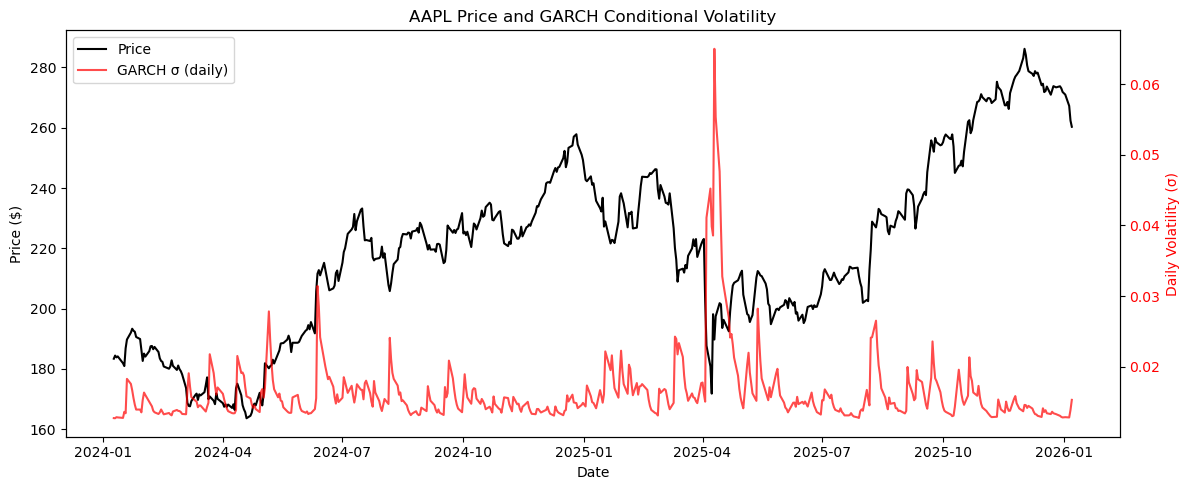

Log return plot saved to: /Users/allenpilipala/BSM_model/docs/AAPL_Price_and_GARCH_Volatility.png


In [114]:
# Daily volatility from GARCH model
df.loc[percent_returns.index, "garch_vol_daily"] = garch_res.conditional_volatility / 100

# Annualized GARCH volatility
df["garch_vol_ann"] = df["garch_vol_daily"] * np.sqrt(252)


def garch_vol_by_horizon(garch_res, max_horizon=5):
    """
    Returns horizon-specific volatility (NOT annualized)
    vols[d] = sigma over d trading days
    """
    forecast = garch_res.forecast(horizon=max_horizon)
    var_f = forecast.variance.iloc[-1].values
    return {d: np.sqrt(np.sum(var_f[:d])) / 100 for d in range(1, max_horizon+1)}

def annualize_from_horizon(sigma_h, days, trading_days=252):
    """
    Returns the annualized volatility corresponding to its time horizons.
    """
    return sigma_h / np.sqrt(days / trading_days)

# Plot the GARCH results
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 5))

# ---- Left axis: Price ----
ax1.plot(df["date"], df[price_col], color="black", label="Price")
ax1.set_xlabel("Date")
ax1.set_ylabel("Price ($)", color="black")
ax1.tick_params(axis="y", labelcolor="black")

# ---- Right axis: GARCH Volatility ----
ax2 = ax1.twinx()
ax2.plot(df["date"], df["garch_vol_daily"], color="red", alpha=0.7, label="GARCH σ (daily)")
ax2.set_ylabel("Daily Volatility (σ)", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# ---- Title ----
plt.title(f"{ticker} Price and GARCH Conditional Volatility")

# ---- Combined legend ----
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

plt.tight_layout()
plt.show()

# Save figure
out_path = docs_dir / f"{ticker}_Price_and_GARCH_Volatility.png"
plt.savefig(out_path, dpi=300)
plt.close()

print("Log return plot saved to:", out_path)

### GARCH vs Rolling Volatility

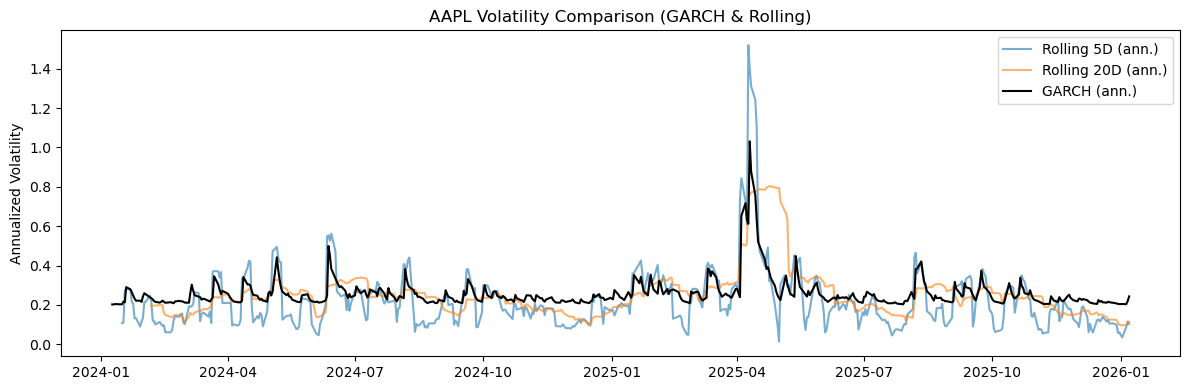

Log return plot saved to: /Users/allenpilipala/BSM_model/docs/AAPL_rolling_volatility_vs._GARCH_volatility.png


In [109]:
# Compare the rolling and GARCH volatility
plt.figure(figsize=(12, 4))

plt.plot(df["date"], df["vol_5d_ann"], label="Rolling 5D (ann.)", alpha=0.6)
plt.plot(df["date"], df["vol_20d_ann"], label="Rolling 20D (ann.)", alpha=0.6)
plt.plot(df["date"], df["garch_vol_ann"], label="GARCH (ann.)", color="black")

plt.title(f"{ticker} Volatility Comparison (GARCH & Rolling)")
plt.ylabel("Annualized Volatility")
plt.legend()
plt.tight_layout()
plt.show()

# Save figure
out_path = docs_dir / f"{ticker}_rolling_volatility_vs._GARCH_volatility.png"
plt.savefig(out_path, dpi=300)
plt.close()

print("Log return plot saved to:", out_path)

### Save Volatility Figures

In [111]:
import pandas as pd
from datetime import date

# Save GARCH model volatility
vol_dict = garch_vol_by_horizon(garch_res, max_horizon=5)

rows = []
for d, sigma in vol_dict.items():
    rows.append({
        "ticker": ticker,
        "model": "garch",
        "horizon_days": d,
        "sigma": sigma,
        "annualized": False,
        "date_generated": date.today()
    })
    
ROLLING_COL = "vol_10d_ann"
rolling_ann = df[ROLLING_COL].iloc[-1]

for d in range(1, 6):
    sigma_h = rolling_ann * np.sqrt(d / 252)

    rows.append({
        "ticker": ticker,
        "model": "hist_rolling",
        "horizon_days": d,
        "sigma": sigma_h,
        "annualized": False,
        "date_generated": date.today()
    })

vol_df = pd.DataFrame(rows)

out_path = Path(data_dir()) / "processed" / "volatility_inputs.csv"
out_path.parent.mkdir(parents=True, exist_ok=True)
vol_df.to_csv(out_path, index=False)

print("Saved volatility inputs to:", out_path)

Saved volatility inputs to: /Users/allenpilipala/BSM_model/data/processed/volatility_inputs.csv
